### Code reference : [Kaggle kernel](https://www.kaggle.com/paultimothymooney/interpret-sign-language-with-deep-learning)

In [0]:
#!pip install tensorflow==1.14.0

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 1.15.2


In [0]:
import sys

print(sys.version_info.major)
# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

3


In [0]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
#import warnings
#warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/asl-alphabet.zip'

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

In [0]:
# helper function for display the represent images
def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = '/content/asl_alphabet_train/asl_alphabet_train/' + letter
    # img_path = base_path + letter #+ '/**'
    # path_contents = os.glob(img_path)
    imgs = np.random.choice(os.listdir(base_path), size = 3)
    
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(base_path + "/" +imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(base_path + "/" +imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(base_path + "/" +imgs[2]))
    return

Samples images for letter Y


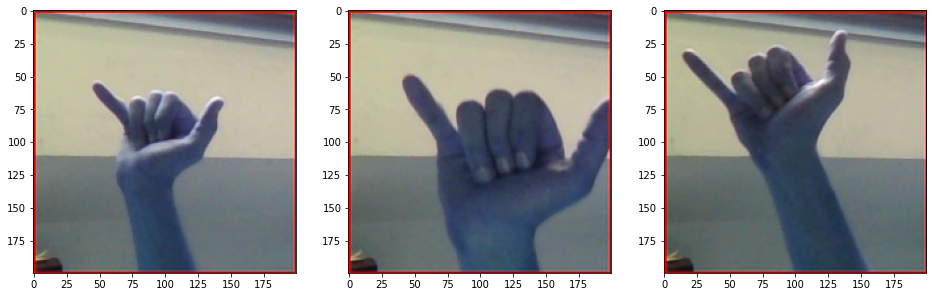

In [0]:
plot_three_samples('Y')

In [0]:
# helper function to get image size
def get_image_size(letter):
  from PIL import Image
  import numpy as np
  import os.path
  base_path = '/content/asl_alphabet_train/asl_alphabet_train/' + letter
  print(f"The base path is {base_path}")
  img = np.random.choice(os.listdir(base_path), size = 1)[0]
  print(f"The type of object returned is {type(img)}")
  print(img)
  image = Image.open(os.path.join(base_path, img))
  #image = Image.fromarray(np.uint8(img))
  print(image.size)

In [0]:
get_image_size('A')

The base path is /content/asl_alphabet_train/asl_alphabet_train/A
The type of object returned is <class 'numpy.str_'>
A150.jpg
(200, 200)


##Data Preparation

In [0]:
imageSize=50
train_dir = '/content/asl_alphabet_train/asl_alphabet_train/'
test_dir =  '/content/asl_alphabet_test/asl_alphabet_test/'

In [0]:
# NEED TO UNCOMMENT RUN THIS CELL ONLY IF 
#X_train, X_test, y_train, y_test, y_trainHot and y_testHot have to generated again

from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 27
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir) 
#X_test, y_test= get_data(test_dir) # Too few images

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2) 

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 29)
y_testHot = to_categorical(y_test, num_classes = 29)

100%|██████████| 3000/3000 [00:19<00:00, 157.13it/s]


In [0]:
#type(X_train)

In [0]:
## Persisting X_train, X_test, y_train, y_test and y_trainHot and y_testHot to Google drive to save some time
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed

items = [("X_train",X_train),
         ("X_test",X_test),
         ("y_train",y_train),
         ("y_test",y_test),
         ("y_trainHot",y_trainHot),
         ("y_testHot",y_testHot)]

path = '/content/drive/My Drive/Berkeley_MIDS/w251/final_project/data/processed/29_labels/'
savez_compressed(path + "X_train" + ".npz", X_train=X_train)
savez_compressed(path + "X_test" + ".npz", X_test=X_test)
savez_compressed(path + "y_train" + ".npz", y_train=y_train)
savez_compressed(path + "y_test" + ".npz", y_test=y_test)
savez_compressed(path + "y_trainHot" + ".npz", y_trainHot=y_trainHot)
savez_compressed(path + "y_testHot" + ".npz", y_testHot=y_testHot)

#for item in items:
#print (f"Saving {item[0]} to {path}")
#savez_compressed(path + item[0] + ".npz", item[0]=item[1])
# save X_train to npy file
#savez_compressed('/content/data.npz', data)

In [0]:
path = '/content/drive/My Drive/Berkeley_MIDS/w251/final_project/data/processed/29_labels'

In [0]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

now = 2020-04-06 12:13:06.994230


In [0]:
# To load the data from Google Drive into X_train, X_test, y_train, y_test and y_trainHot and y_testHot
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

print(f"start of load = {now}")

# load numpy array from npz file
from numpy import load
# load dict of arrays

X_train_data= load(path + "X_train" + ".npz")
X_train = X_train_data['X_train']
X_test_data = load(path + "X_test" + ".npz")
X_test = X_test_data['X_test']
y_train_data = load(path + "y_train" + ".npz")
y_train =  y_train_data['y_train']
y_test_data = load(path + "y_test" + ".npz")
y_test = y_test_data['y_test']
y_trainHot_data = load(path + "y_trainHot" + ".npz")
y_trainHot = y_trainHot_data['y_trainHot']
y_testHot_data = load(path + "y_testHot" + ".npz")
y_testHot = y_testHot_data['y_testHot']

now = datetime.now()
print(f"end of load = {now}")


# saved_items = [("X_train",X_train_new),
#          ("X_test",X_test_new),
#          ("y_train",y_train_new),
#          ("y_test",y_test_new),
#          ("y_trainHot",y_trainHot_new),
#          ("y_testHot",y_testHot_new)]

# for item in saved_items:
#   item[1] = load(path + item[0] + '.npz')

start of load = 2020-04-04 20:13:50.648849


BadZipFile: ignored

In [0]:
print(type(X_train_new))
print(vars(X_train_new))
print(X_train.shape, X_train_new.shape)
(y_testHot==y_testHot_new).all()

NameError: ignored

In [0]:
y_train.shape

(69600,)

In [0]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

Step 3: Vizualize Data

The min/max pixel values are already scaled between 0 and 1

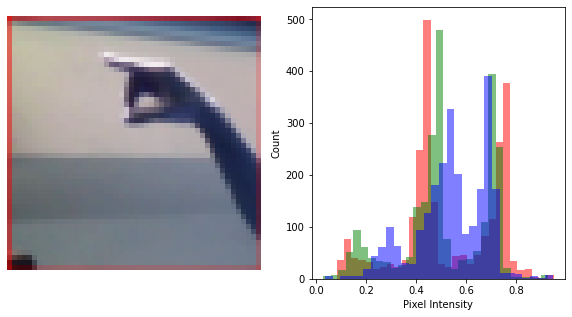

In [0]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

3 images from category "A"

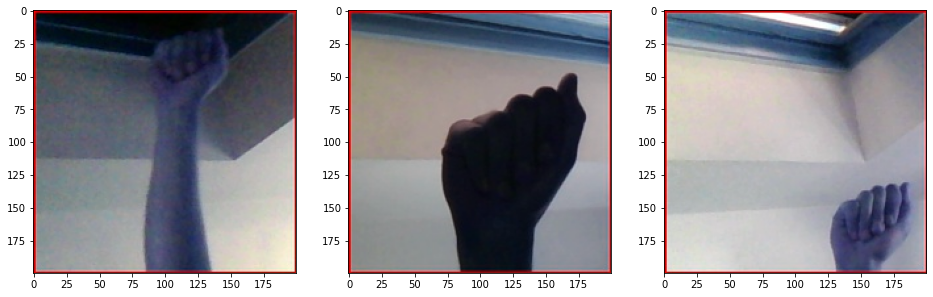

In [0]:
multipleImages = glob('/content/asl_alphabet_train/asl_alphabet_train/A/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]))
    #;
plotThreeImages(multipleImages)

3 images from category "B"

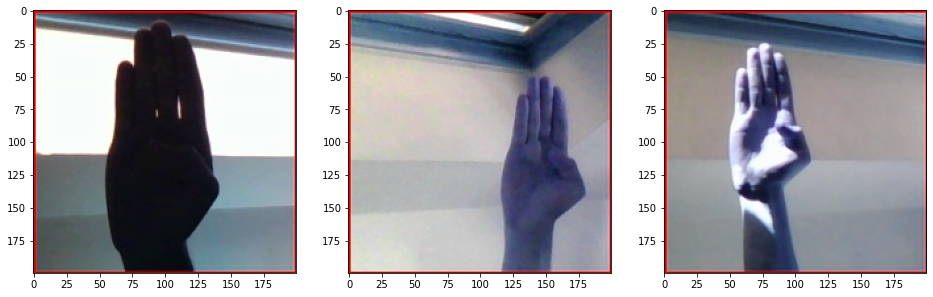

In [0]:
multipleImages = glob('/content/asl_alphabet_train/asl_alphabet_train/B/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])) 
plotThreeImages(multipleImages)

20 images from category "A"

A


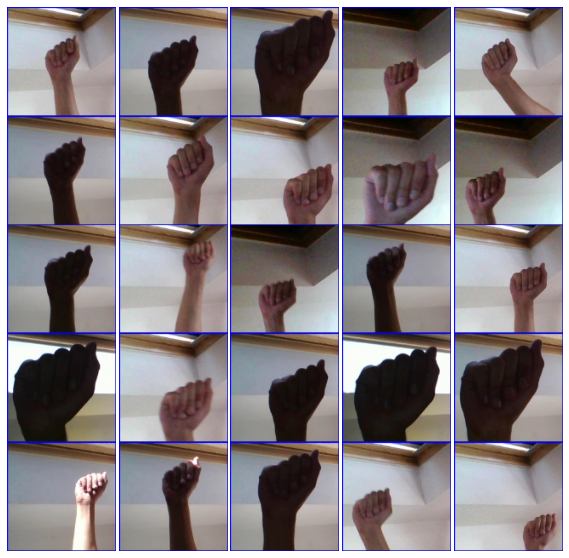

In [0]:
print("A")
multipleImages = glob('/content/asl_alphabet_train/asl_alphabet_train/A/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "B"

B


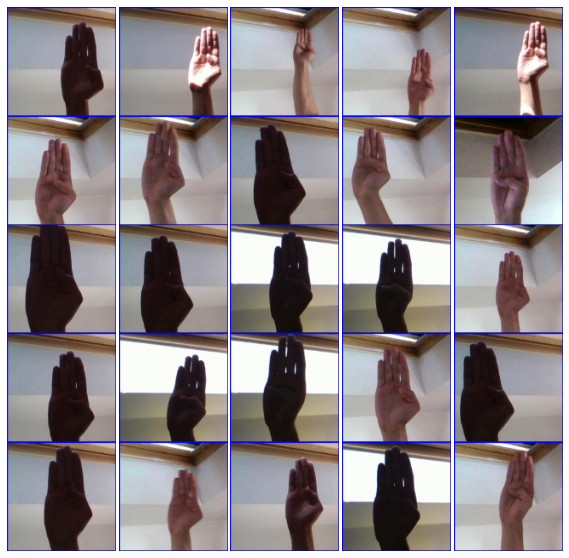

In [0]:
print("B")
multipleImages = glob('/content/asl_alphabet_train/asl_alphabet_train/B/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}


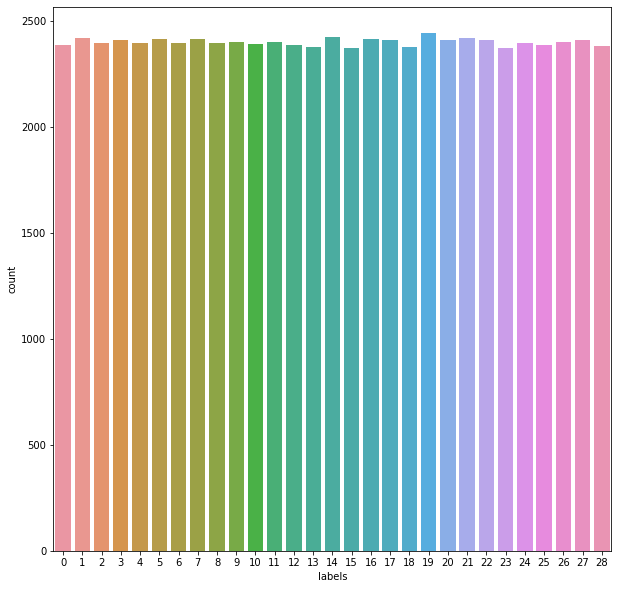

In [0]:
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [0]:
len(list(map_characters.values()))

29

Step 4: Define Helper Functions

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Step 5: Evaluate Classification Models

Transfer learning w/ VGG16 Convolutional Network

In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [0]:
map_characters1 = map_characters
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path1 = '/content/drive/My Drive/Colab Notebooks/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '/content/drive/My Drive/Colab Notebooks/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
#pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    print(f"epochs={numepochs} class_weight={classweight}")
    print(f"xtrain size={xtrain.size}")
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    return model


In [0]:
model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,29,10,optimizer1,map_characters1)




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0 

In [0]:
from keras import backend as K

# Create, compile and train model...

frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, "/content/drive/My Drive/Colab Notebooks/models/Kaggle_PTMooney/29_labels/", "vgg16_model.pb", as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 43 variables.
INFO:tensorflow:Converted 43 variables to const ops.


'/content/drive/My Drive/Colab Notebooks/models/Kaggle_PTMooney/29_labels/vgg16_model.pb'

In [0]:
def score_and_plot(model,xtest,ytest,labels):
  y_pred = model.predict(xtest)
  print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
  Y_pred_classes = np.argmax(y_pred,axis = 1) 
  Y_true = np.argmax(ytest,axis = 1) 
  confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
  plotKerasLearningCurve()
  plt.show()
  plot_learning_curve(history)
  plt.show()
  plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
  plt.show()

In [0]:
score_and_plot(model, X_test, y_testHot, map_characters)


              precision    recall  f1-score   support

           A       0.86      0.91      0.88       612
           B       0.89      0.96      0.92       580
           C       0.99      0.98      0.98       606
           D       0.96      0.97      0.97       589
           E       0.94      0.83      0.88       607
           F       0.96      0.97      0.97       584
           G       0.97      0.93      0.95       606
           H       0.96      0.99      0.97       584
           I       0.92      0.92      0.92       607
           J       0.96      0.97      0.96       599
           K       0.93      0.88      0.91       608
           L       0.96      0.99      0.97       600
           M       0.87      0.86      0.86       614
           N       0.94      0.82      0.87       624
           O       0.99      0.93      0.96       576
           P       0.93      0.97      0.95       629
           Q       0.99      0.98      0.99       585
           R       0.87   

ValueError: ignored

<Figure size 720x360 with 0 Axes>